In [2]:
import os
import sys
import shutil
import time
#sys.path.append('../SimuTMofMMF')
#sys.path.append('D:\Dropbox\PythonWS\SimuTMofMMF')

import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.animation as manimation
import numpy as np

import pyMMF
import SLM_MMF


#from inputImage import getTestImage
import inputImage 

import imp
import scipy as sp

from numba import c16, jit

from matplotlib.font_manager import FontProperties

from functions import show,generate_data


imp.reload(pyMMF)
imp.reload(SLM_MMF)
imp.reload(inputImage )


# plt.ion()

<module 'inputImage' from '/automount/nfs/curie/promo123/spopoff/fermat/SimuERC/inputImage.py'>

In [5]:
#fiber settings

settings = {}
settings['a'] = 10.#62.5
settings['NA'] = 0.275#0.27
settings['n1'] = 1.45
settings['areaSize'] = 2.8*settings['a']
settings['npoints'] = 2**7
settings['wl'] = 0.6328
settings['npola'] = 1


# modulator settings
settings['curvature'] = 5e3#5e3
#settings['range_curv'] = 5.e3
settings['length'] = 200e3
settings['Nmodulators'] = 40
settings['Nsteps'] = 10
settings['length_between_piezos'] = 33e3

## optimization settings
# number of configurations of disorder, we take one emage for each config
settings['Nconfig'] = 1

locals().update(settings)

## to save video
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

In [243]:
generate_data(settings = settings,show = False, save_file = '20um.npz')

2019-09-10 17:13:00,633 - pyMMF.core [DEBUG  ]  Debug mode ON.
2019-09-10 17:13:00,633 [DEBUG  ]  Debug mode ON.
DEBUG:pyMMF.core:Debug mode ON.
2019-09-10 17:13:00,637 - pyMMF.core [INFO   ]  Solving the spatial eigenvalue problem for mode finding.
2019-09-10 17:13:00,637 [INFO   ]  Solving the spatial eigenvalue problem for mode finding.
INFO:pyMMF.core:Solving the spatial eigenvalue problem for mode finding.
2019-09-10 17:13:00,640 - pyMMF.core [INFO   ]  Use close boundary condition.
2019-09-10 17:13:00,640 [INFO   ]  Use close boundary condition.
INFO:pyMMF.core:Use close boundary condition.
2019-09-10 17:13:11,582 - pyMMF.core [INFO   ]  Solver found 102 modes is 10.95 seconds.
2019-09-10 17:13:11,582 [INFO   ]  Solver found 102 modes is 10.95 seconds.
INFO:pyMMF.core:Solver found 102 modes is 10.95 seconds.
2019-09-10 17:13:11,583 - pyMMF.core [DEBUG  ]  Mode data stored in memory.
2019-09-10 17:13:11,583 [DEBUG  ]  Mode data stored in memory.
DEBUG:pyMMF.core:Mode data stored i

In [12]:
def corr_img(A,B):
    return np.corrcoef(A,B)[0,1]

def soft_thresholding(A, alpha):
    B = np.zeros(A.shape,dtype=np.complex128)
    B[np.abs(A)>alpha] = A[np.abs(A)>alpha]-alpha
    return B

def soft_thresholding_real(A, alpha):
    B = np.zeros(A.shape,dtype=np.complex128)
    B[np.real(A)>alpha] = A[np.real(A)>alpha]-alpha
    return B

def soft_thresholding_real2(A, alpha):
    B = np.zeros(A.shape,dtype=np.complex128)
    B[np.real(A)>alpha] = A[np.real(A)>alpha]-complex(1,1)*alpha
    return B

def apply_mask(A,mask):
    if (len(A.shape) == 1):
        print('ok')
        return A*quarter_mask.flatten()   
    else:
        n = A.shape[1]
        return A*np.tile(quarter_mask.flatten()[:,None],(1,n))
    
def space_to_mode(A,mode_basis,normalization = True):
    A = np.dot(mode_basis.transpose().conjugate(),A)
    return A/np.linalg.norm(A,axis = 0)

# def draw_plot(fig_data,rec):
#     #fig_data['line_std'].set_ydata(np.sin(rec['std']))
#     fig_data['line_ax'].plot(rec['std'])
#     #print(rec['std'])
#     plt.draw()
# #     plt.show()
#     fig_data['fig'].canvas.draw()
# show(np.abs(apply_mask(M0[:,-1],quarter_mask).reshape([npoints]*2)))


In [198]:
## Create the fiber
#
#profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)
#profile.initParabolicGRIN(n1=n1,a=a,NA=NA)
#
### find the mode profiles for the straight fiber
#
#solver = pyMMF.propagationModeSolver()
#solver.setIndexProfile(profile)
#solver.setWL(wl)
#
#NmodesMax = pyMMF.estimateNumModesGRIN(wl,a,NA)+10
#
#modes0 = solver.solve(nmodesMax=NmodesMax,boundary = 'close',curvature = curvature)
#
#M0 = modes0.getModeMatrix(npola = npola)
#plt.figure();plt.imshow(np.abs(M0),aspect='auto')
#
#Nmodes = modes0.number
#
#TM = modes0.getPropagationMatrix(length,npola = npola)
#
#np.savez('mat_128.npz', TM=TM, M0=M0, settings=settings)

## Load data

<IPython.core.display.Javascript object>


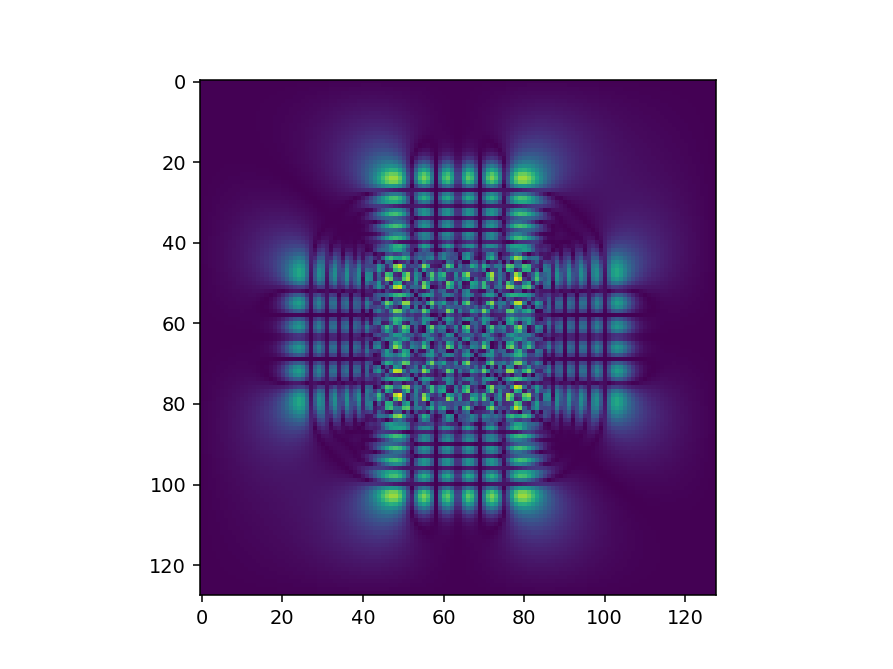

In [3]:
data = np.load('mat_128.npz')
#data = np.load('OM1.npz')
# TM = data['TM']
M0 = data['M0']
Nmodes = M0.shape[1]
npoints = int(np.sqrt(M0.shape[0]))
plt.figure()
plt.imshow(np.abs(M0[:,-1].reshape([npoints]*2)))


## Generate input image and output speckle

<IPython.core.display.Javascript object>


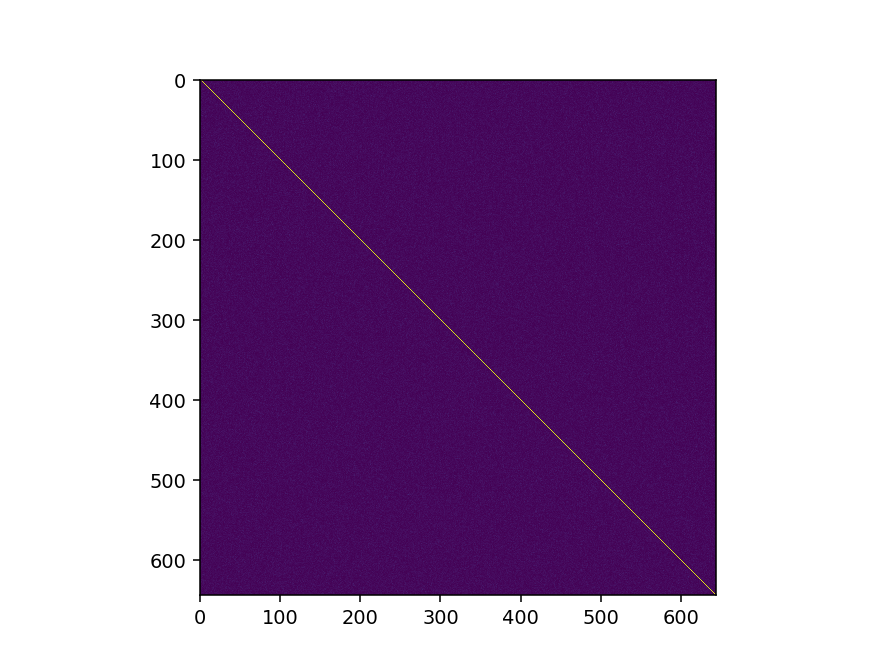

In [7]:
# Generate TMs
sigma_off_diag = 0.02
def get_TM(Nmodes,sigma_off_diag):
    return np.diag(np.exp(1j*np.random.rand(Nmodes)*2.*np.pi))+ \
           np.random.randn(Nmodes,Nmodes)*sigma_off_diag +\
           1j*np.random.randn(Nmodes,Nmodes)*sigma_off_diag 
TMs = np.stack([get_TM(Nmodes,sigma_off_diag) for _ in range(Nconfig)])
TMs.shape

show(np.abs(TMs[0]))

(16384, 1)


<IPython.core.display.Javascript object>


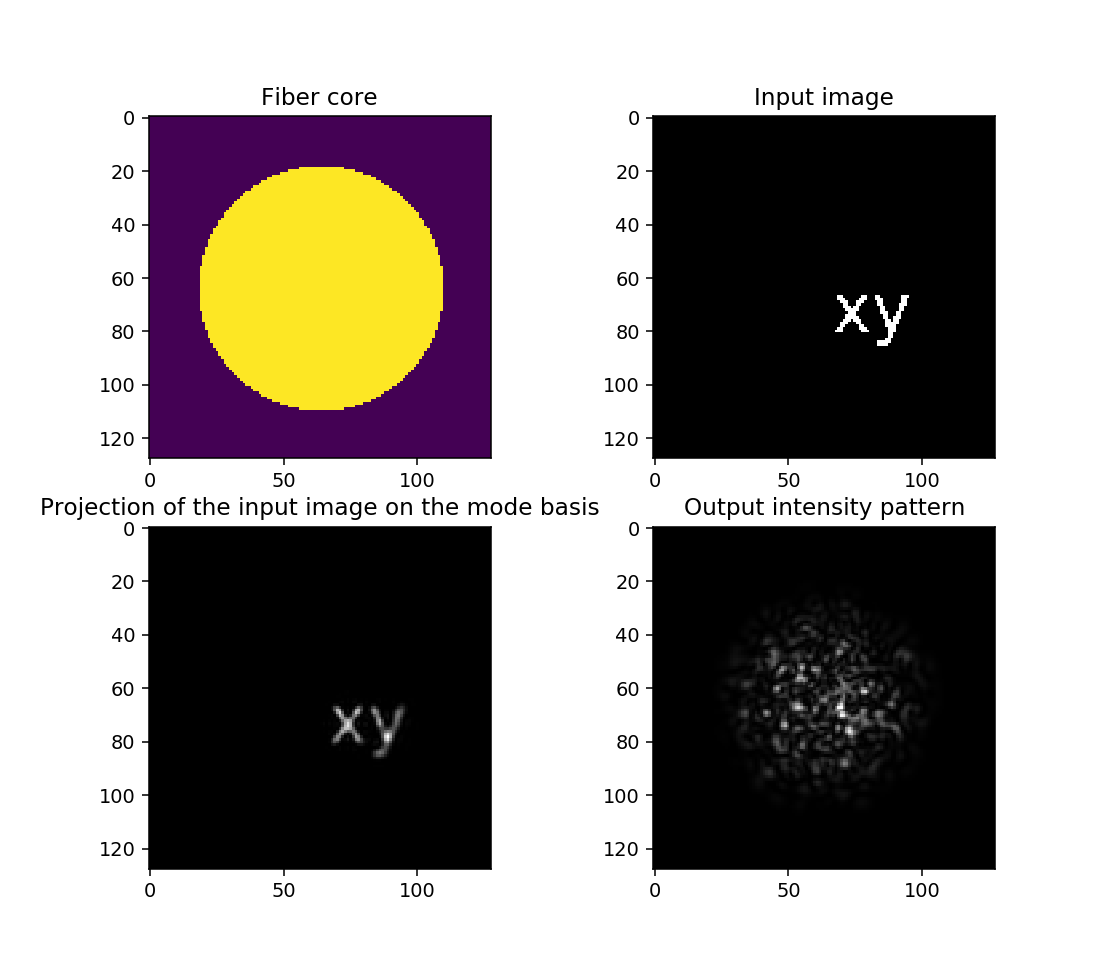

In [8]:
#
X,Y = np.meshgrid(np.arange(npoints),np.arange(npoints))
fiber_core = np.zeros([npoints]*2)
fiber_core[(X-npoints/2)**2+(Y-npoints/2)**2 < (npoints*a/areaSize)**2] = 1.

#%%
inputField = inputImage.getTestImage(npoints,content ='xy',scale = 0.2,shift=[11,7])

# projection of the input image on the propagating modes
inputProj = (M0.conjugate().transpose()).dot(inputField.flatten())

outputProj = []
outputField = []

# Generate the outputs (in the mode and pixel basis) for each TM
outputProjs = TMs.dot(inputProj).transpose()
outputFields = M0.dot(outputProjs)
print(outputFields.shape)



ind = 0

projected_image = (np.abs(M0.dot(inputProj))**2).reshape([npoints,npoints])

plt.figure(figsize = [8,7])
plt.subplot(221)
plt.imshow(fiber_core)
plt.title('Fiber core')
#plt.imshow(np.real(M0[:,-1].reshape([npoints,npoints])))
plt.subplot(222)
plt.imshow(np.abs(inputField)**2,cmap=plt.cm.gray)
plt.title('Input image')
plt.subplot(223)
plt.imshow(projected_image,cmap=plt.cm.gray)
plt.title('Projection of the input image on the mode basis')
plt.subplot(224)
plt.imshow((np.abs(outputFields[...,ind])**2).reshape([npoints,npoints]),cmap=plt.cm.gray)
plt.title('Output intensity pattern')
plt.subplots_adjust(wspace=0.4)
plt.show()

# plt.figure()
# plt.title('Projection of in/output into mode basis')
# plt.plot(np.abs(inputProj))
# plt.plot(np.abs(outputProj[ind]),'r+')
# plt.show()

In [9]:
# Use only a quarter of the input (too avoid symmetry ambiguity)
quarter_mask  = (X > npoints/2) * (Y>npoints/2)
#plt.figure()
#plt.imshow(quarter_mask)

#%%
    
N_ITER = 1000
STAGNATION = 1e-5
N_STAG = 20

#mu = 0.5
sigma = [0.6]*2

# Output = normalized output complex field resulting from the (unkown) input image for each TM
Out_mode = outputProjs
Out_mode = Out_mode/np.linalg.norm(Out_mode,axis = 0)

# Output in the mode basis
Out_space = M0.dot(Out_mode)



# Initial guess for the image: same coefficient for every mode + normalization
#Image_mode = np.ones((Nmodes,Nconfig),dtype=np.complex128)
Image_mode = np.random.randn(Nmodes,Nconfig).astype(np.complex128)
Image_mode = Image_mode/np.linalg.norm(Image_mode,axis = 0)

# Resulting images into the pixel space
Image_space_all = M0.dot(Image_mode)

# Average the resuts from all the configurations
# Image_space = Image_space_all.mean(axis=1)
Image_space_mean = Image_space_all.mean(axis=1)
Image_space = Image_space_all+np.tile(Image_space_mean[:,None],(1,Nconfig))

Prev_Image_space = np.zeros(Image_space_mean.shape,dtype=np.complex128)
#Image_space = np.ones((npoints*npoints),dtype=np.complex128)

step1 = 200
step2 = 1000
truc_beg = 1.0e2
truc_end = 1.0e2
truc_vec = [truc_beg]*step1+np.linspace(truc_beg,truc_end,step2-step1).tolist()+[truc_end]*(N_ITER-step2-step1)

step1 = 100
step2 = 1000
mu_beg = 0.5
mu_end = 0.5
mu_vec = [mu_beg]*step1+np.linspace(mu_beg,mu_end,step2-step1).tolist()+[mu_end]*(N_ITER-step2-step1)




<IPython.core.display.Javascript object>


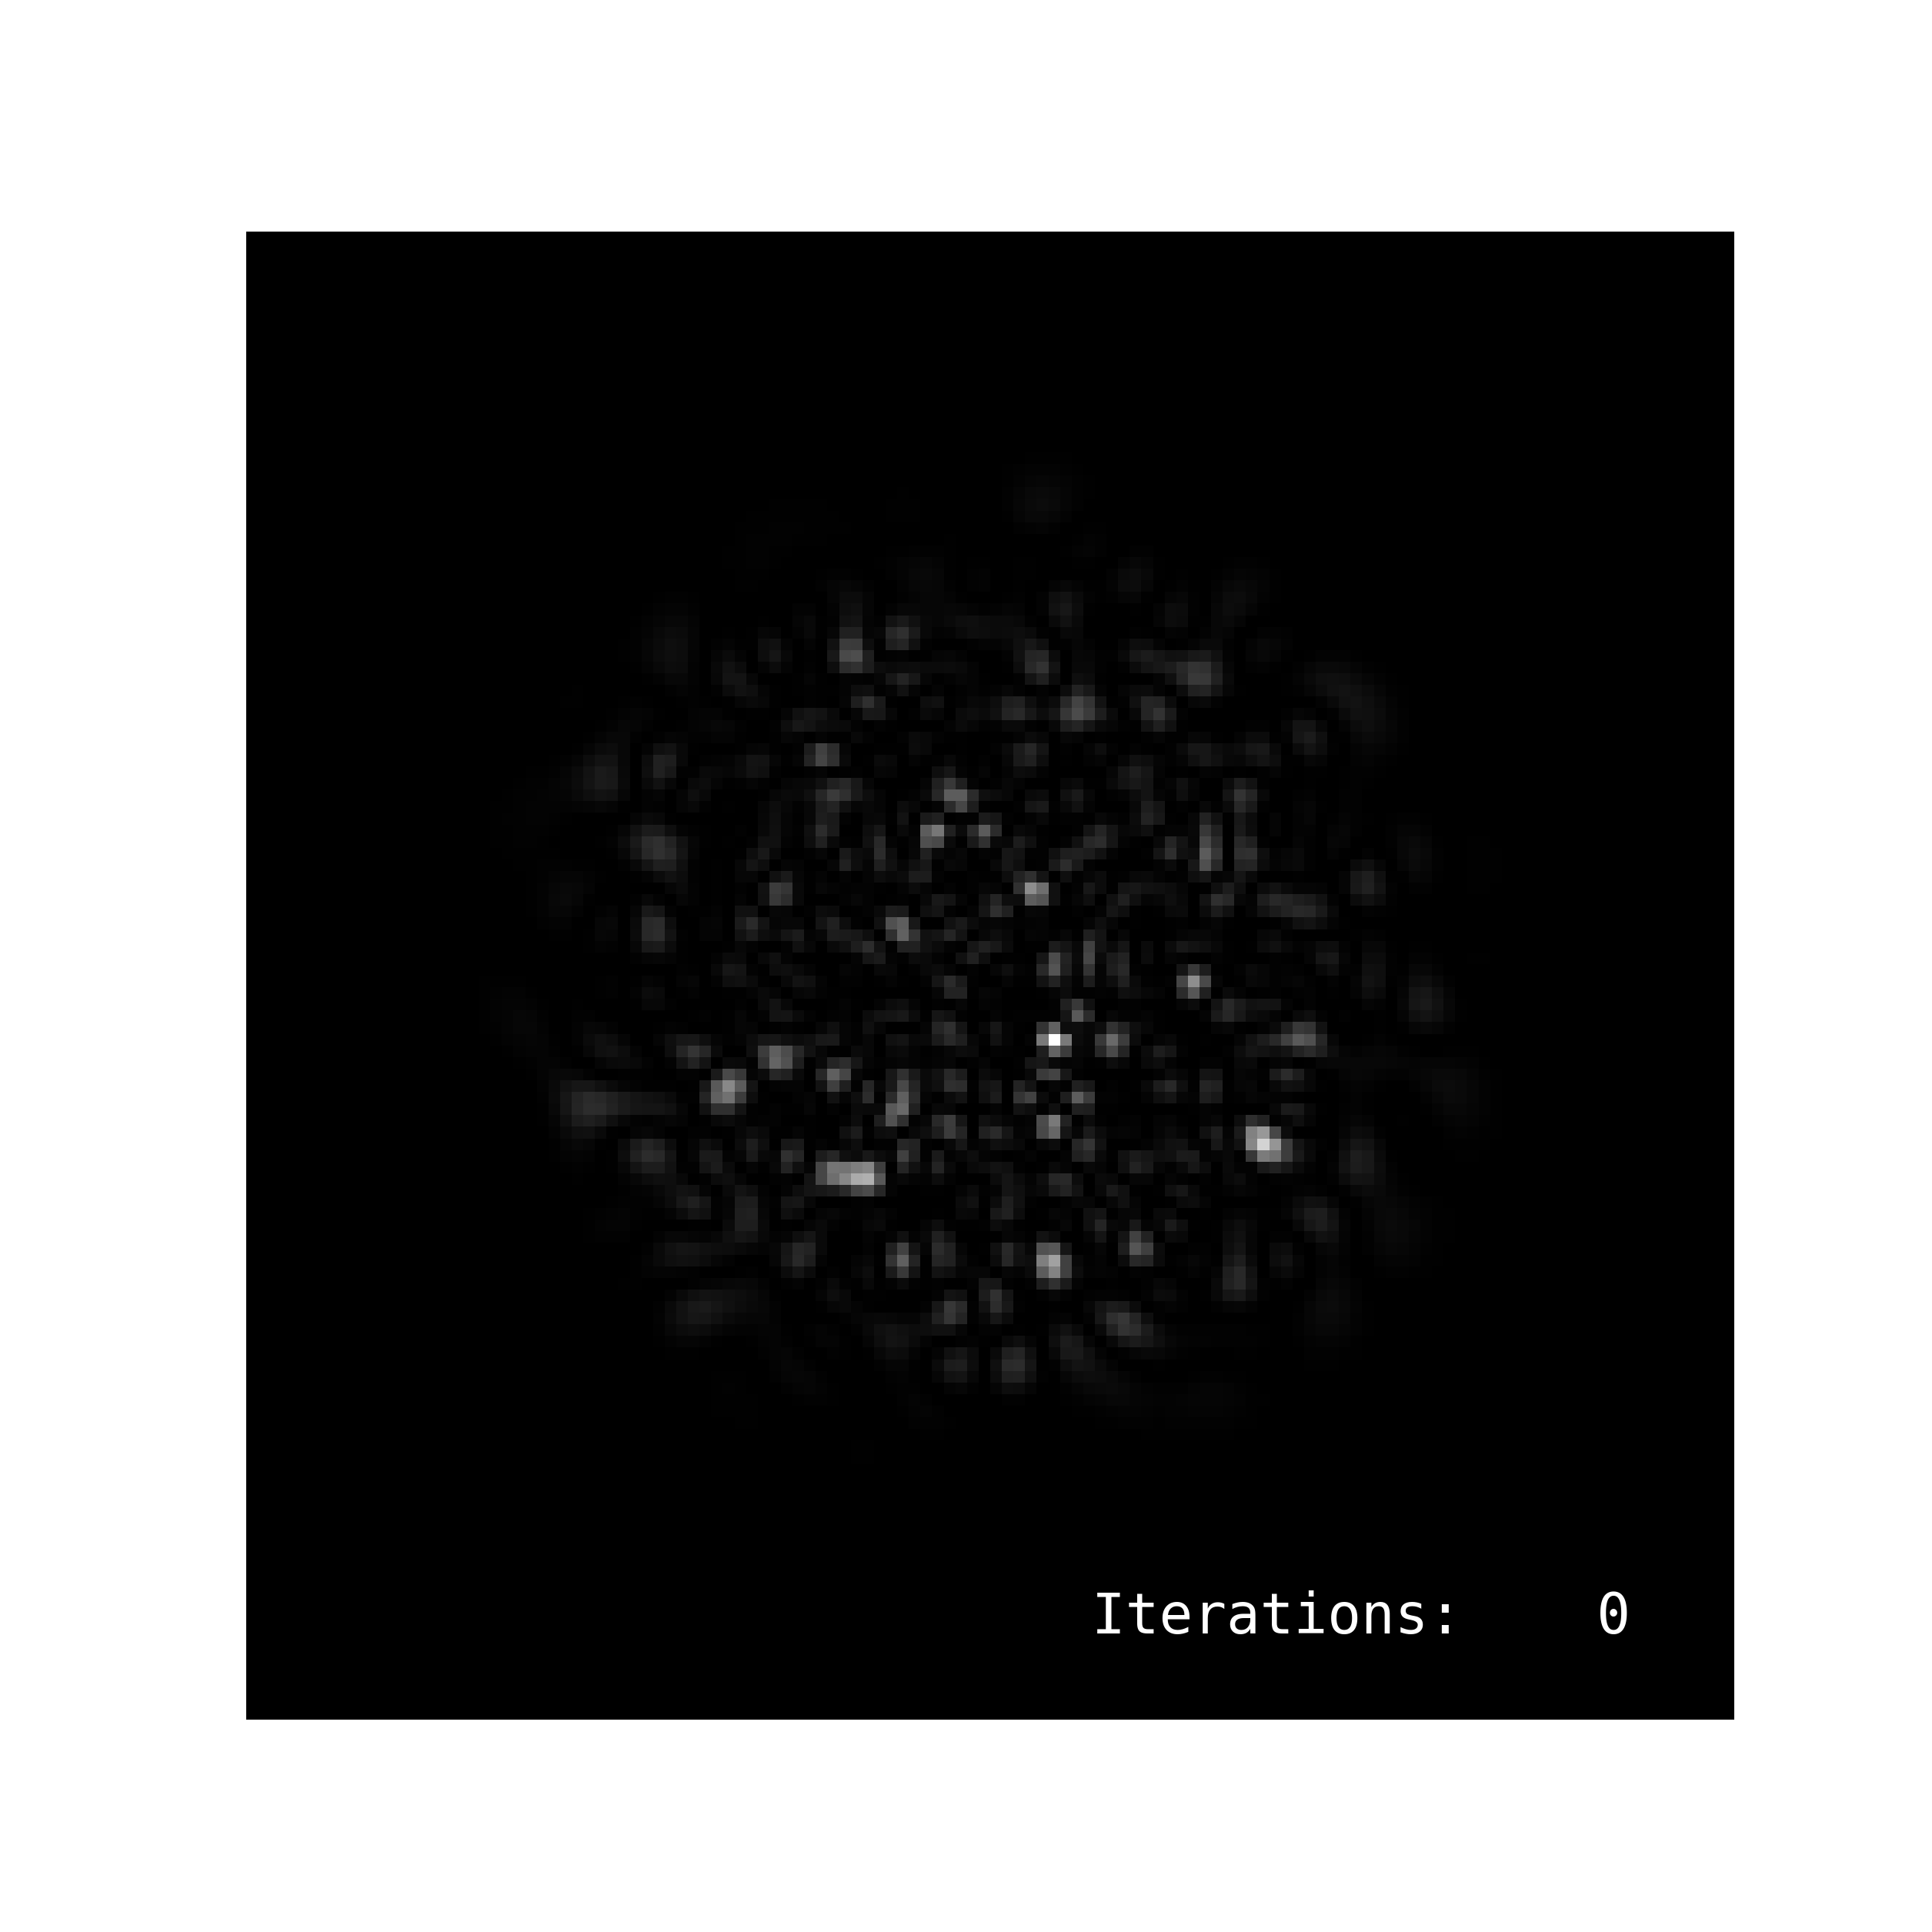

(-0.5, 127.5, 127.5, -0.5)

In [10]:
font = FontProperties()
font.set_family('monospace')

# plt.ion()
fig = plt.figure(figsize=(12, 12), dpi=150); ax = fig.add_subplot(111)
#fig = plt.figure(figsize=(18, 8), dpi=80)
#ax = fig.add_subplot(131)
#ax.set_axis_off()
#im = ax.imshow((np.abs(M0.dot(inputProj))**2).reshape([npoints]*2),aspect='equal')
#ax = fig.add_subplot(132)
ax.set_axis_off()

im = ax.imshow((np.abs(Image_space_mean)**2).reshape([npoints]*2),aspect='equal',interpolation = 'nearest',cmap=plt.cm.gray)
text = ax.text(0.93, 0.05, 'Iterations: {:>4}'.format(str(0)),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontproperties=font,
        color='white', fontsize=25)
plt.axis('scaled')

## Optimization

In [13]:
# how many iterations the system stagates
# stop when it reaches N_STAG
count_stag = 0
record_video = False

std_K = 1e8
t0 = time.time()

rec = {}
rec['std_config'] = []
rec['std'] = []
rec['corr'] = []
rec['stag'] = []

with writer.saving(fig, "evolution.mp4", 100):
    for i in range(N_ITER):
#        if i < 100 or std_K>1.:
#            alpha = mu*np.mean(np.abs(Image_space))#outputField)) 
#        else:
#            alpha = 1.*mu*np.mean(np.abs(Image_space))
        mu = mu_vec[i]
        
        alpha = mu*np.mean(np.abs(Image_space))
        
        # STEP 1: APPLY PRIOR IN THE PIXEL BASIS
        
        # Step 1-1: Soft thresholding is the pixel space to enforce sparsity
        Image_space = soft_thresholding(Image_space, alpha*0.5)
        # Step 1-2: Mask to get only one quarter of the image
#         Image_space = Image_space*quarter_mask.flatten()
        Image_space = apply_mask(Image_space,quarter_mask)
        

        # Step 1-3: Filter?
#        Image_space = sp.ndimage.filters.gaussian_filter(np.real(Image_space).reshape([npoints]*2), sigma, mode='constant').reshape([-1]) + \
#                      complex(0,1)*sp.ndimage.filters.gaussian_filter(np.imag(Image_space).reshape([npoints]*2), sigma, mode='constant').reshape([-1])
#                      
        
        
#        # Sparse in Fourier
#        Image_FFT = np.fft.fft2(Image_space.reshape([npoints]*2))
#        alpha_fft = 1.*np.mean(np.abs(Image_FFT))
#        Image_FFT = soft_thresholding(Image_FFT,alpha_fft)
#        Image_space = np.fft.ifft2(Image_FFT).reshape([-1])
#        plt.figure(); plt.imshow(np.abs(Image_space).reshape([npoints]*2))
        
        ##Image_mode = M0.transpose().conjugate().dot(Image_space)
        
        ## STEP 2: GO INTO MODE BASIS
        
        Image_mode = space_to_mode(Image_space,M0,normalization = True)
         
        ## STEP 3: APPLY PRIORS IN THE MODE BASIS 
        
        # Estimate the TM assuming the image is the true one 
        # We take only the diagonal elements as we know the matrix should be ~ diagonal
#         K_lin = Out_mode/Image_mode[:,None]
        K_lin = Out_mode/Image_mode#[:,None]

#         break
        
        # BONUS
    #    alpha2 = 1e-4*np.mean(np.abs(K_lin))
    #    K_lin = soft_thresholding(K_lin,alpha2)
        amp_K = np.abs(K_lin)
        std_K = np.mean(np.std(amp_K,axis = 0))

#         print('-'*10)
#         print(std_K[:5])
#         print(np.abs(K_lin[:5,0]))
#         print(np.abs(K_lin[:5,1]))
#         print(Image_mode.shape)
#         break
        
        
        # Take only the phase
#        K_lin = np.exp(complex(0,1)*np.angle(K_lin))
        # Or push everything up         
        truc = truc_vec[i]*np.mean(np.abs(K_lin))
#         K_lin = (np.abs(K_lin) + truc + np.random.randint(0,50,K_lin.shape))*np.exp(complex(0,1)*np.angle(K_lin))
        K_lin = (np.abs(K_lin) + truc)*np.exp(complex(0,1)*np.angle(K_lin))

        
        # Normalization
        K_lin = K_lin/np.linalg.norm(K_lin,axis = 0)*np.sqrt(Nmodes)

        
        
        # STEP 4: GO BACK IN PIXEL BASIS
        
        # a. Estimate the object assuming the TM is the true one
        Image_mode = Out_mode/K_lin
        Image_mode = Image_mode/np.linalg.norm(Image_mode,axis = 0)

        
        #b. Project back to pixel space
        # Resulting images into the pixel space
        Image_space_all = M0.dot(Image_mode)
#         if i ==1:
#             break

        # Average the resuts from all the configurations
        Image_space_mean = np.abs(Image_space_all).mean(axis=1)

        Image_space = Image_space_all+0.1*np.tile(Image_space_mean[:,None],(1,Nconfig))

        # Record standard deviation and
        rec['std_config'].append(np.mean(np.std(Image_space,axis=1)))
        rec['std'].append(std_K)
#         rec['corr'].append(np.abs(corr_img(Image_space,np.abs(inputField.reshape([-1])))))
        rec['corr'].append(np.abs(corr_img(
            np.abs(Image_space_mean)**2,
            projected_image.reshape([-1])
        )))
        rec['stag'].append(np.linalg.norm(Prev_Image_space-Image_space_mean)/np.linalg.norm(Image_space_mean))
        
        
        if np.mod(i,10) == 0 or i == 0:

            time_ = time.time()-t0
            #print('Iteration %g/%g \t std = %0.4f\t stagnation = %0.2E \t time = %0.1f' % (i,N_ITER,rec['std'][-1],rec['stag'][-1],time_))
            print("Iteration {}/{}\t std = {:0.4f}\t corr = {:0.2E}\t stag = {:0.6E}".format(
                i, N_ITER,
                rec['std'][-1],
                rec['corr'][-1],
                rec['stag'][-1]
            ))
#             print(mu)
            if i== 0 or (rec['corr'][-1] > np.max(rec['corr'][:-1])):
                best = (np.abs(Image_space_mean)**2).reshape([npoints]*2)

            if record_video:
                for i, line in enumerate(ax.lines):
                    ax.lines.pop(i)
                    text.remove()
                im.set_data((np.abs(Image_space_mean)**2).reshape([npoints]*2))
    #             plt.figure()
    #             plt.imshow((np.abs(Image_space)**2).reshape([npoints]*2))
    #             plt.show()
    #             text.set_text('Iterations: {:>4}'.format(str(i+1)))
    ##            pl.set_ydata(amp_K)
    ##            ax = plt.gca()
    ##            # recompute the ax.dataLim
    ##            ax.relim()
    ##            # update ax.viewLim using the new dataLim
    ##            ax.autoscale_view()

                writer.grab_frame()
                fig.canvas.draw()

        if rec['stag'][-1] <= STAGNATION:
            count_stag += 1
            if count_stag == N_STAG:
                print('Iteration %g/%g \t std = %0.4f\t stagnation = %0.2E' % (i,N_ITER,rec['std'][-1],rec['stag'][-1]))
                break
        else:
            count_stag = 1
        # Store the image for the calculation of the stagnation
        Prev_Image_space = Image_space_mean
        
#         if i ==5:
#             break
    

Iteration 0/1000	 std = 22.4153	 corr = 3.87E-01	 stag = 1.000000E+00
Iteration 10/1000	 std = 1.2623	 corr = 4.31E-01	 stag = 1.174963E-04
Iteration 20/1000	 std = 1.2661	 corr = 4.31E-01	 stag = 3.419829E-08
Iteration 30/1000	 std = 0.7304	 corr = 4.64E-01	 stag = 7.417917E-02
Iteration 40/1000	 std = 0.4492	 corr = 5.13E-01	 stag = 3.098595E-02
Iteration 50/1000	 std = 0.4216	 corr = 5.40E-01	 stag = 1.944231E-02
Iteration 60/1000	 std = 0.4066	 corr = 5.56E-01	 stag = 2.022992E-02
Iteration 70/1000	 std = 0.3934	 corr = 5.98E-01	 stag = 2.290589E-02
Iteration 80/1000	 std = 0.4074	 corr = 6.36E-01	 stag = 1.610195E-02
Iteration 90/1000	 std = 0.4156	 corr = 6.81E-01	 stag = 1.281095E-02
Iteration 100/1000	 std = 0.4024	 corr = 7.11E-01	 stag = 1.003405E-02
Iteration 110/1000	 std = 0.3965	 corr = 7.32E-01	 stag = 9.856530E-03
Iteration 120/1000	 std = 0.3948	 corr = 7.46E-01	 stag = 8.438929E-03
Iteration 130/1000	 std = 0.3918	 corr = 7.48E-01	 stag = 1.029939E-02
Iteration 140/10

<IPython.core.display.Javascript object>


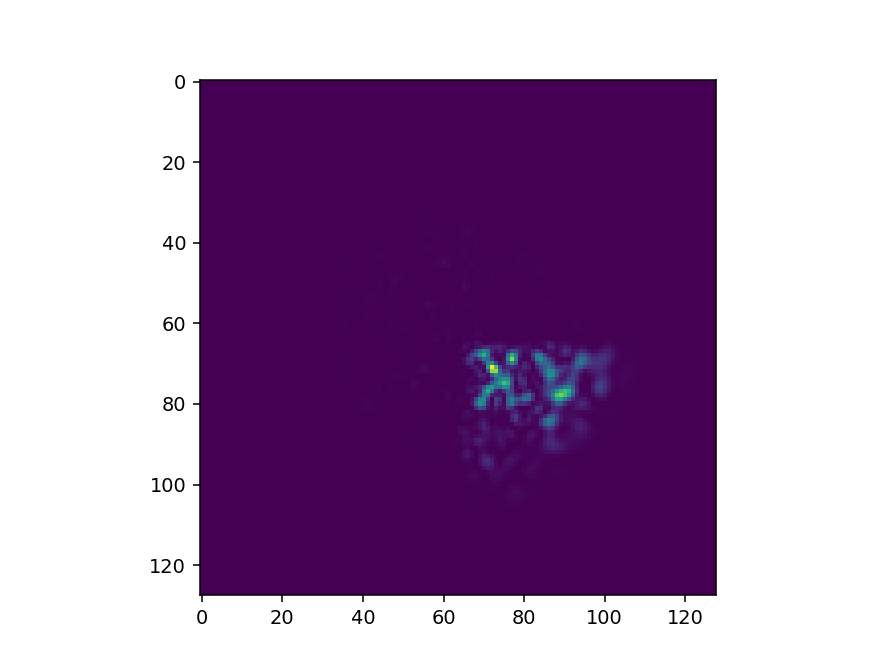

<IPython.core.display.Javascript object>


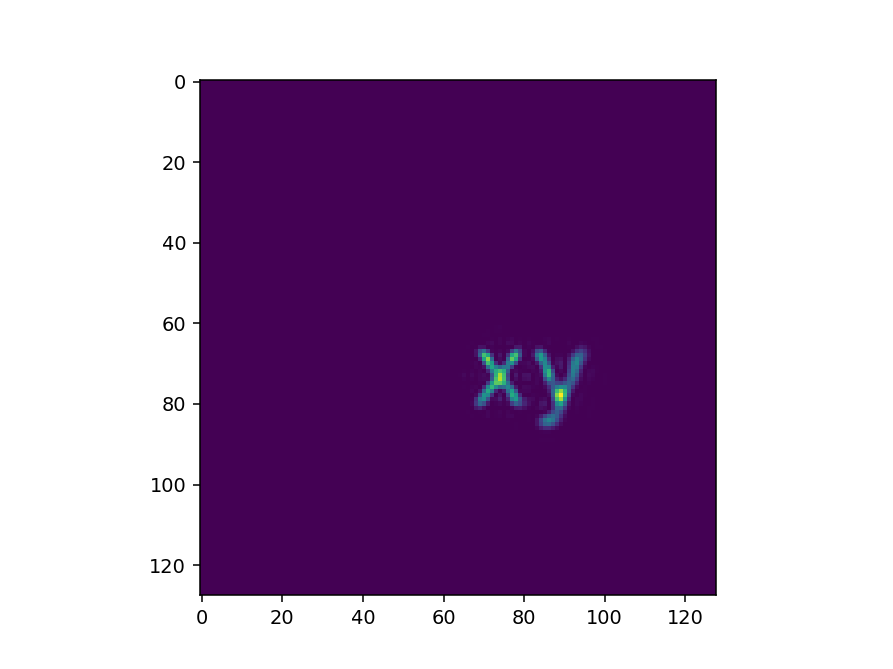

In [14]:
show(best)
show(projected_image)

In [ ]:
np.mean(Image_space,axis=1).shape

In [159]:
Image_space_all.mean(axis=1)[None,:].shape

(1, 16384)

In [151]:
# np.std(np.abs(K_lin),axis = 0)

K_lin2 = Out_mode/Image_mode[:,None]
print(np.std(np.abs(K_lin2),axis = 0))
Image_mode.shape
np.abs(K_lin2)[:5,0]

# show(np.abs(Image_space_all[...,0].reshape([npoints]*2))-(np.abs(Image_space_all[...,1].reshape([npoints]*2))))
# show(np.abs(Image_space_all[...,1].reshape([npoints]*2)))
# show(np.abs(Image_space_all[...,0].reshape([npoints]*2)))
# Image_mode = Out_mode/K_lin
# print(Image_mode[:5,0])
# print(Image_mode[:5,1])
# print((Out_mode[:,0]/K_lin[:,0])[:5])
# print((K_lin[:,0])[:5])
# print((K_lin[:,1])[:5])

# print(Image_mode.shape)
# print(Image_space.shape)
# print(M0.shape)
# Image_mode2 = np.dot(M0.transpose().conjugate(),Image_space)
# print(Image_mode2.shape)

[1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981
 1340.39976981 1340.39976981 1340.39976981 1340.39976981 1340.39976981]


array([0.46743801, 0.60508963, 0.56443446, 0.94624073, 0.50235718])

In [29]:
print((Out_mode[...,0]/K_lin[...,0])[:5])
print((Out_mode[...,1]/K_lin[...,1])[:5])
print((K_lin[...,0])[:5])
print((K_lin[...,1])[:5])

K_lin.shape

[ 0.05127549-0.02912075j -0.11904187+0.06415973j  0.03484972-0.02043747j
 -0.15545505+0.08044389j  0.01476657-0.01142264j]
[ 0.05127549-0.02912075j -0.11904187+0.06415973j  0.03484972-0.02043747j
 -0.15545505+0.08044389j  0.01476657-0.01142264j]
[ 0.69702808+0.71448684j -0.48666744+0.8716378j   0.99194913-0.11293104j
 -0.1892238 -0.98043047j -0.98522666-0.16270361j]
[ 0.89638052+0.43913727j  0.00858648+0.99826045j  0.98836817+0.14087182j
  0.94482636+0.32303669j -0.96010666-0.27447994j]


(644, 4)

<IPython.core.display.Javascript object>


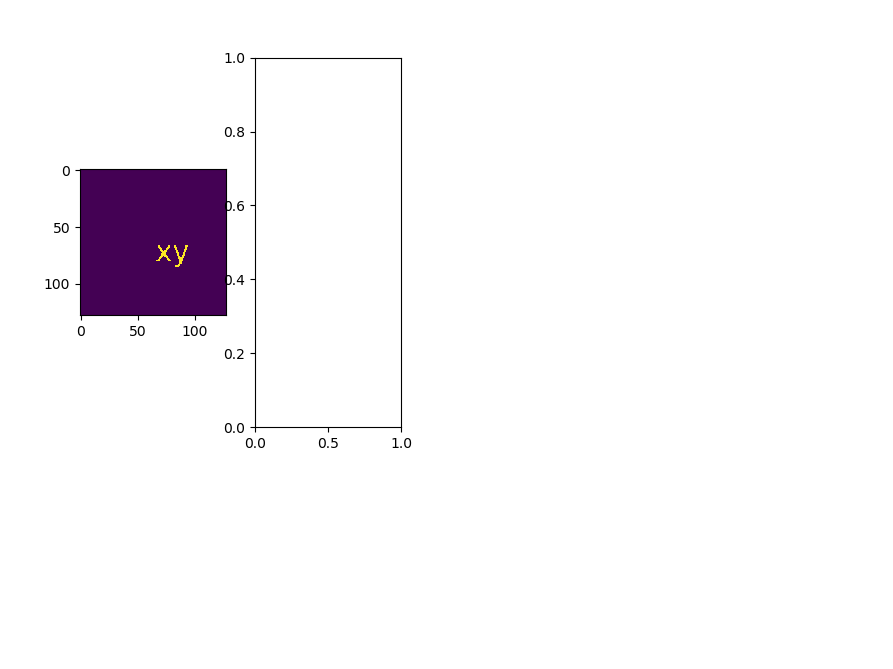

ValueError: cannot reshape array of size 65536 into shape (128,128)

In [105]:
plt.figure()
plt.subplot(131)
plt.imshow(np.abs(inputField).reshape([npoints]*2))
plt.subplot(132)
plt.imshow(np.abs(Out_space).reshape([npoints]*2))
plt.subplot(133)
plt.imshow(best)
plt.draw()
plt.show()